# Resolutions

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division
import os
import re
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate_from_llhp
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [495]:
# before SPE priors
#rootdir = '/data/justin/retro/recos/2018-03-28/tblptlog/'
# with SPE priors
#rootdir = '/data/justin/retro/recos/2018-04-05.1/1460/'
#simdir = '/data/icecube/sim/ic86/retro/1460/'
# gerco l7:
#rootdir = '/data/justin/retro/recos/2018-04-06.0/14600/'
#rootdir = '/data/justin/retro/recos/2018-04-10.3/14600/'
rootdir = '/data/peller/retro/recos/2018.04.19.02_loguniform/14600/'
simdir = '/data/icecube/sim/ic86/retro/14600/'

p = re.compile(r'evt(\d*)-llhp.npy')

events_list = []

# this is just because of a mismatch
#new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

prev_subdir = None

tot = 0
mn_failed = 0
estimator_failed = 0

#n_llh = 100000

for subdir, dirs, files in os.walk(rootdir):
    #print subdir
    # load truth

    
    if len(files) == 0:
        continue
    
    if not subdir == prev_subdir:
        #with open(os.path.join(simdir, os.path.basename(subdir), 'mc_truth.pkl'), 'rb') as f:
        #    truth_file = pickle.load(f)
        #with open(os.path.join(simdir, os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Track.pkl'), 'rb') as f:
        #    track_file = pickle.load(f)
        #with open(os.path.join(simdir, os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Cascade.pkl'), 'rb') as f:
        #    cascade_file = pickle.load(f)
        #with open(os.path.join(simdir, os.path.basename(subdir), 'recos/Pegleg_Fit_MN.pkl'), 'rb') as f:
        #    pegleg_file = pickle.load(f)
        spefit_file = np.load(os.path.join(simdir, os.path.basename(subdir), 'recos/SPEFit2.npy'))
        truth_file = np.load(os.path.join(simdir, os.path.basename(subdir), 'truth.npy'))
        pegleg_file = np.load(os.path.join(simdir, os.path.basename(subdir), 'recos/Pegleg_Fit_MN.npy'))
        prev_subdir == subdir
    
    for file in files:
        if tot % 100 == 0:
            print tot
        if p.match(file):
            tot +=1
            event_number = int(re.sub('[^0-9]', '', file))

            llhp_data = np.load(os.path.join(subdir, file))
            #if len(llhp_data['llh']) < 5000:
            #    print 'event %i bad (N=%i)'%(event_number, len(llhp_data['llh']))
            #    mn_failed += 1
            #    continue
            
            meta_fname = os.path.join(subdir, 'evt%i-multinest_meta.pkl'%event_number)
            with open(meta_fname, 'rb') as f:
                meta = pickle.load(f)
            #llhp_data.dtype.names = new_names
            try:
                estimator = estimate_from_llhp(llhp_data, meta=meta)
            except IndexError:
                print 'event %i estimator failed'%(event_number)
                estimator_failed += 1
                continue
                
            event = {}
            
            # --- Retro ---
            # construct "energy"
            estimator['mean']['energy'] = estimator['mean']['cascade_energy'] + estimator['mean']['track_energy']
            estimator['weighted_mean']['energy'] = estimator['weighted_mean']['cascade_energy'] + estimator['weighted_mean']['track_energy']
            estimator['median']['energy'] = estimator['median']['cascade_energy'] + estimator['median']['track_energy']
            estimator['weighted_median']['energy'] = estimator['weighted_median']['cascade_energy'] + estimator['weighted_median']['track_energy']
            estimator['best']['energy'] = estimator['best']['cascade_energy'] + estimator['best']['track_energy']
            estimator['low']['energy'] = estimator['low']['cascade_energy'] + estimator['low']['track_energy']
            estimator['high']['energy'] = estimator['high']['cascade_energy'] + estimator['high']['track_energy']
            # add to dict
            event['n_llh'] = len(llhp_data['llh'])
            event['median_llh'] = np.median(llhp_data['llh'])
            event['min_llh'] = np.min(llhp_data['llh'])
            event['max_llh'] = np.max(llhp_data['llh'])
            for key in estimator['mean'].keys():
                event['retro_%s_mean'%key] = estimator['mean'][key]
                event['retro_%s_weighted_mean'%key] = estimator['weighted_mean'][key]
                event['retro_%s_median'%key] = estimator['median'][key]
                event['retro_%s_weighted_median'%key] = estimator['weighted_median'][key]
                event['retro_%s_best'%key] = estimator['best'][key]
                event['retro_%s'%key] = estimator['weighted_median'][key]
                event['retro_%s_high'%key] = estimator['high'][key]
                event['retro_%s_low'%key] = estimator['low'][key]
                event['retro_%s_delta'%key] = estimator['high'][key] - estimator['low'][key]
                
            # --- Truth ---                
            #truth = truth_file[event_number]
            #truth['track_azimuth'] = truth['azimuth']
            #truth['track_zenith'] = np.arccos(truth['coszen'])
            #truth['track_energy'] = truth['highest_energy_daughter_energy']
            #truth['neutrino_energy'] = truth['energy']
            #truth['energy'] = truth['track_energy'] + truth['cascade_energy'] 
            #truth['time'] = truth['time']
            #event.update(truth)
            # --- Truth (npy) ---                
            truth = truth_file[event_number]
            event['track_azimuth'] = truth['azimuth']
            event['track_zenith'] = np.arccos(truth['coszen'])
            event['track_energy'] = truth['highest_energy_daughter_energy']
            event['neutrino_energy'] = truth['energy']
            event['x'] = truth['x']
            event['y'] = truth['y']
            event['z'] = truth['z']
            event['time'] = truth['time']
            event['cascade_energy'] = truth['cascade_energy']
            event['track_energy'] = truth['highest_energy_daughter_energy']
            event['energy'] = event['track_energy'] + event['cascade_energy'] 
            for name in truth_file.dtype.names:
                event['truth_'+name] = truth[name]
            #truth['time'] = truth['time']
            #event.update(truth)

            # --- hybrid ---
            #event['pegleg_x'] = track_file[event_number]['x']
            #event['pegleg_y'] = track_file[event_number]['y']
            #event['pegleg_z'] = track_file[event_number]['z']
            #event['pegleg_time'] = track_file[event_number]['time']
            #event['pegleg_track_azimuth'] = track_file[event_number]['azimuth']
            #event['pegleg_track_zenith'] = track_file[event_number]['zenith']
            #event['pegleg_track_energy'] = track_file[event_number]['energy']
            #event['pegleg_cascade_energy'] = cascade_file[event_number]['energy']
            #event['pegleg_energy'] = event['pegleg_track_energy'] + event['pegleg_cascade_energy']

            # --- Pegleg ---
            event['pegleg_x'] = pegleg_file[event_number]['x']
            event['pegleg_y'] = pegleg_file[event_number]['y']
            event['pegleg_z'] = pegleg_file[event_number]['z']
            event['pegleg_time'] = pegleg_file[event_number]['time']
            event['pegleg_track_azimuth'] = pegleg_file[event_number]['azimuth']
            event['pegleg_track_zenith'] = pegleg_file[event_number]['zenith']
            event['pegleg_track_energy'] = pegleg_file[event_number]['track_energy']
            event['pegleg_cascade_energy'] = pegleg_file[event_number]['cascade_energy']
            event['pegleg_energy'] = pegleg_file[event_number]['energy']
            
            # --- SPEFit ---
            spefit = spefit_file[event_number]
            event['spefit_x'] = spefit['x']
            event['spefit_y'] = spefit['y']
            event['spefit_z'] = spefit['z']
            event['spefit_time'] = spefit['time']
            event['spefit_track_zenith'] = spefit['zenith']
            event['spefit_track_azimuth'] = spefit['azimuth']

            
            events_list.append(event)

0
100
100
200
200
300
300
400
400
500
500
600
600
600
700
800
800


In [496]:
#write
df = pandas.DataFrame(events_list)
#df.to_pickle('pde_2018-04-19.01_14600.pkl')
#df.to_pickle('data_greco_14000.pkl')
#df.to_pickle('jll_2018-04-06.0.pkl')
#df.to_pickle('data_greco_14000_only100kllhs.pkl')

# read
#df = pandas.read_pickle('jll_2018-04-06.0.pkl')
df = df.astype(np.float32)
# drop all nan values
#df = df.dropna()
df = df.fillna(1e-3)
events = pn.PointData(df)

In [497]:
print 'files :', tot
print 'good :',len(events)
print 'failed :',mn_failed
print 'estimator failed :', estimator_failed

files : 824
good : 824
failed : 0
estimator failed : 0


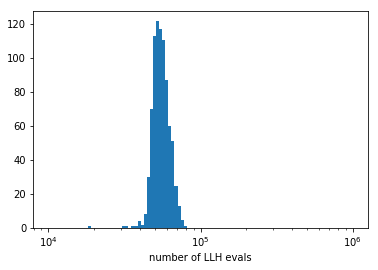

In [498]:
plt.hist(events['n_llh'], bins=np.logspace(4,6,100))
plt.gca().set_xscale('log')
plt.gca().set_xlabel('number of LLH evals')
plt.savefig('n_llhs.png')
#plt.gca().set_yscale('log')

[0.81581059 3.94644682]
[0.82494686 3.92804238]


(0, 100)

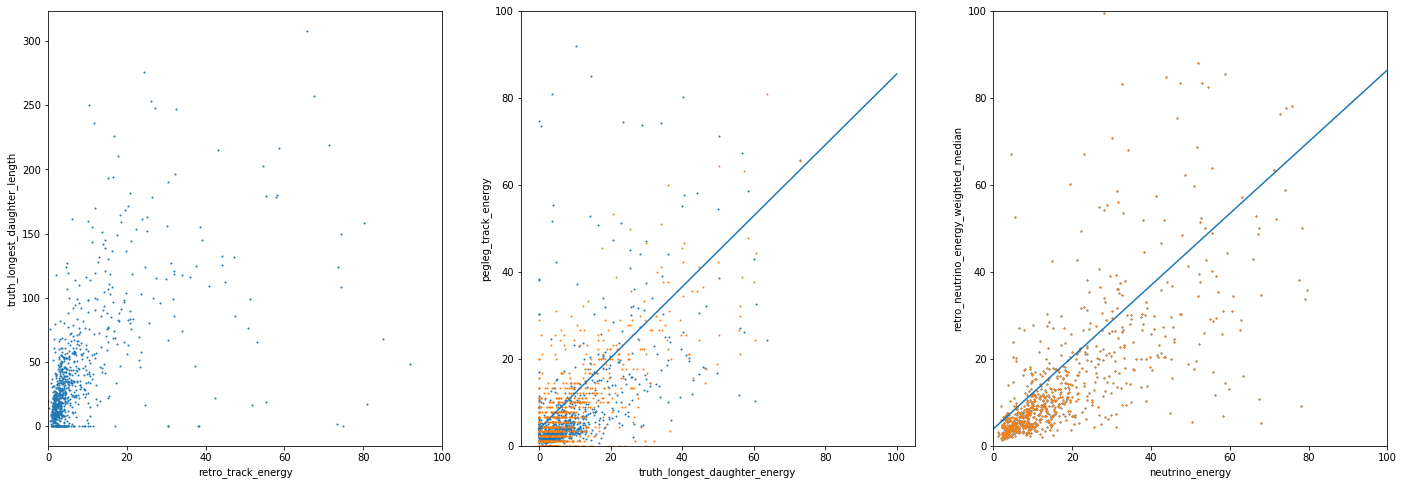

In [499]:
events.vars
fig, axes = plt.subplots(figsize=(24, 8), ncols=3, nrows=1)
#events.plot_2d(fig, axes[0], 'truth_longest_daughter_energy', 'truth_longest_daughter_length', s=1)
events.plot_2d(fig, axes[0], 'retro_track_energy', 'truth_longest_daughter_length', s=1)
#axes[1].plot([0,100], [0,100])
events.plot_2d(fig, axes[1], 'truth_longest_daughter_energy', 'retro_track_energy_weighted_median', s=1)
fit = np.polyfit(events['truth_longest_daughter_energy'],events['retro_track_energy_weighted_median'],1)
print fit
fit_fn = np.poly1d(fit) 
x = np.linspace(0,100,100)
axes[1].plot(x, fit_fn(x))
events.plot_2d(fig, axes[1], 'truth_longest_daughter_energy', 'pegleg_track_energy', s=1)
axes[1].set_ylim((0,100))
axes[0].set_xlim((0,100))
events.plot_2d(fig, axes[2], 'neutrino_energy', 'retro_energy', s=1)
events['retro_neutrino_energy_weighted_median'] = events['retro_energy'] #/ 0.6 - 4 
events.plot_2d(fig, axes[2], 'neutrino_energy', 'retro_neutrino_energy_weighted_median', s=1)
fit = np.polyfit(events['neutrino_energy'],events['retro_neutrino_energy_weighted_median'],1)
print fit
fit_fn = np.poly1d(fit) 
x = np.linspace(0,100,100)
axes[2].plot(x, fit_fn(x))
#events.plot_2d(fig, axes[2], 'pegleg_energy', 'neutrino_energy', s=1)
axes[2].set_xlim((0,100))
axes[2].set_ylim((0,100))
#axes[2].plot([0,100], [0,100])

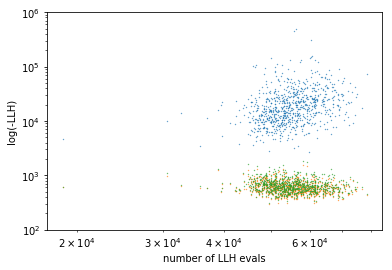

In [500]:
plt.scatter(events['n_llh'], -events['min_llh'], s=0.1)
plt.scatter(events['n_llh'], -events['max_llh'], s=0.1)
plt.scatter(events['n_llh'], -events['median_llh'], s=0.1)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('number of LLH evals')
plt.gca().set_ylabel('log(-LLH)')
plt.gca().set_ylim(100,1000000)
plt.savefig('llh_corr.png')

In [501]:
#mask = np.logical_and(np.logical_and(np.logical_and(events['retro_track_zenith_delta'] < 10, events['retro_x_delta'] < 50),events['retro_y_delta'] < 50), events['retro_z_delta'] < 30)

In [502]:
events.mask = None

In [503]:
#energy_corr_cscd = 0.9
#energy_corr_trck = 1.3
#energy_offset = 2.
#events['retro_neutrino_energy_weighted_median'] = energy_corr_trck*events['retro_track_energy_weighted_median'] + energy_corr_cscd*events['retro_cascade_energy_weighted_median'] + energy_offset
#events['retro_neutrino_energy_low'] = energy_corr_trck*events['retro_track_energy_low'] + energy_corr_cscd*events['retro_cascade_energy_low'] + energy_offset
#events['retro_neutrino_energy_high'] = energy_corr_trck*events['retro_track_energy_high'] + energy_corr_cscd*events['retro_cascade_energy_high'] + energy_offset
events['pegleg_neutrino_energy'] = events['pegleg_energy']

In [504]:
e_bins = pn.Grid()
e_bins['energy'].edges = np.array([1, 5 ,  10, 15,  20 , 25, 40,  100.   ,500     ])
#np.logspace(np.log10(np.nanmin(events['energy'])),np.log10(np.nanmax(events['energy'])),11)
hists = pn.GridData(e_bins)

/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


high quality percentage =  20
x
y
z
time
track_zenith
track_azimuth
track_energy
cascade_energy
energy


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in log


neutrino_energy

--- retro ---


--- hybrid ---


--- spefit ---



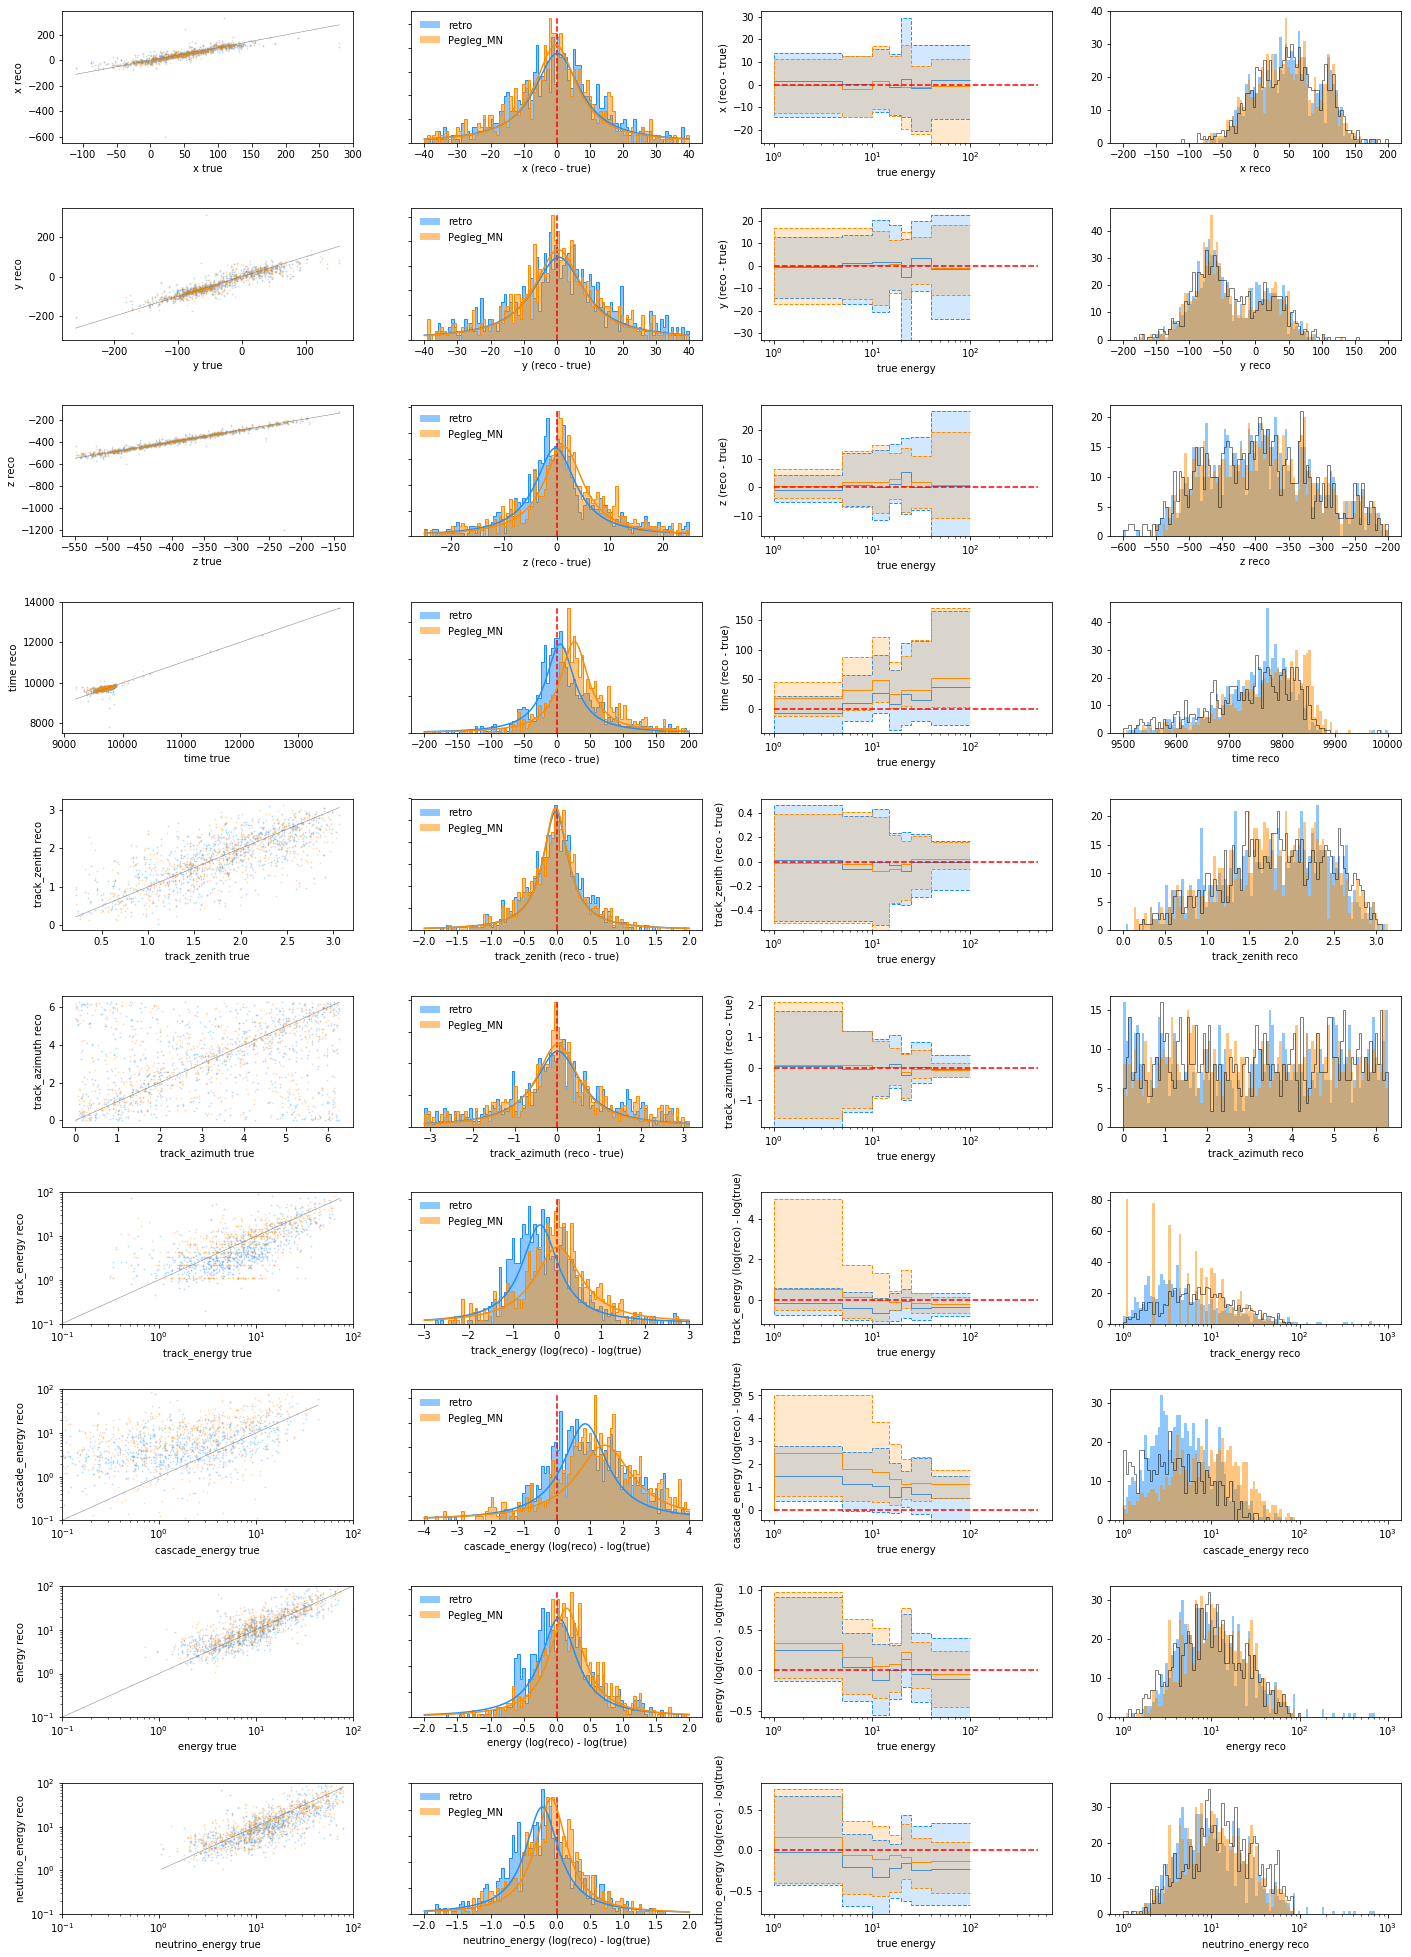

In [505]:
fig, axes = plt.subplots(figsize=(24, 35), ncols=4, nrows=10)
plt.subplots_adjust(hspace = 0.5)

res = []
pegres = []
speres = []

estimator = '_weighted_median'
#estimator = '_best'
#estimator = '_median'


events['retro_energy_logdelta'] = np.log10(0.5*events['retro_energy_delta']/events['retro_energy'+estimator])

mask = events['z'] > -550
#mask = np.logical_and(mask, events['retro_energy'+estimator] > 5.6)
#mask = np.logical_and(mask, events['retro_energy'+estimator] < 56)
#mask = np.logical_and(mask, events['pegleg_energy'] > 5.6)
#mask = np.logical_and(mask, events['pegleg_energy'] < 56)

#high_quality_evts = np.logical_and(events['retro_energy_delta'] < 20, events['retro_track_zenith_delta'] < 0.7)
high_quality_evts = np.logical_and(events['retro_energy_logdelta'] < np.percentile(events['retro_energy_logdelta'], 100), events['retro_track_zenith_delta'] < np.percentile(events['retro_track_zenith_delta'], 20))
#high_quality_evts = np.logical_and(high_quality_evts, events['retro_x_delta'] < 30)
#high_quality_evts = np.logical_and(high_quality_evts, events['retro_y_delta'] < 30)
#high_quality_evts = np.logical_and(high_quality_evts, events['retro_z_delta'] < 20)
#high_quality_evts = np.logical_and(high_quality_evts, events['retro_time_delta'] < 50)
low_quality_evts = ~high_quality_evts

high_quality_evts = np.logical_and(mask, high_quality_evts)
low_quality_evts = np.logical_and(mask, low_quality_evts)

percentage = int(np.sum(high_quality_evts)/np.sum(mask)*100)
print 'high quality percentage = ',percentage

'''
recos = ['retro', 'retro', 'retro']#, 'pegleg']
labels = ['retro', 'retro rest', 'retro best %i%%'%percentage, 'Pegleg_MN']
colors = ['gray', 'dodgerblue', 'yellowgreen', 'darkorange']
masks = [mask, low_quality_evts, high_quality_evts, mask]
'''
recos = ['retro', 'pegleg']
labels = ['retro', 'Pegleg_MN']
colors = ['dodgerblue', 'darkorange']
masks = [mask, mask]
#'''

for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy', 'neutrino_energy']):
    print dim
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    ax3 = axes[i,2]
    ax4 = axes[i,3]

    
    # diagonal
    d = [np.nanmin(events[dim][mask]),np.nanmax(events[dim][mask])]
    ax1.plot(d,d, color='gray', linewidth=0.5)

    if dim in ['x','y']:
        bins = np.linspace(-40, 40, 101)
        bins2 = np.linspace(-200, 200, 101)
    elif dim == 'z':
        bins = np.linspace(-25, 25, 101)
        bins2 = np.linspace(-600, -200, 101)
    elif dim == 'time':
        bins = np.linspace(-200, 200, 101)
        bins2 = np.linspace(9500, 10000, 101)
    elif 'azimuth' in dim:
        bins = np.linspace(-np.pi, np.pi, 101)
        bins2 = np.linspace(0, 2*np.pi, 101)
    elif 'zenith' in dim:
        bins = np.linspace(-2, 2, 101)
        bins2 = np.linspace(0, np.pi, 101)
    elif dim == 'cascade_energy':
        bins = np.linspace(-4, 4, 101)
        bins2 = np.logspace(0, 3, 101)     
    elif dim == 'track_energy':
        bins = np.linspace(-3, 3, 101)
        bins2 = np.logspace(0, 3, 101)      
    elif 'energy' in dim:
        bins = np.linspace(-2, 2, 101)
        bins2 = np.logspace(0, 3, 101)
    else:
        raise NotImplementedError()
    
    for reco, mask, color, label in zip(recos, masks, colors, labels):
        key = reco+'_'+dim
        if reco == 'retro':
            key += estimator

        # ------------scatter plots---------------
        events.mask = mask
        events.plot_2d(fig, ax1, dim, key, color=color, s=1, alpha=0.2)
        events.mask = None
        if 'energy' in dim:
            ax1.set_xlim((1e-1,1e2))
            ax1.set_ylim((1e-1,1e2))
    
        # ------------diff histos---------------
        d_key = reco+'_d_'+dim
        
        if 'energy' in dim:
            events[d_key] = np.log(events[key]) - np.log(events[dim])
            events[d_key][~np.isfinite(events[d_key])] = 5
        else:
            events[d_key] = events[key] - events[dim]
        #events[d_key] = events[d_key][np.isfinite(diff)]
        if 'azimuth' in dim:
            events[d_key]  = (events[d_key] + np.pi)%(2*np.pi) - np.pi
            
        events.mask = mask
        ax2.hist(events[d_key], bins=bins, normed=True, color=color, alpha=0.5, label=label, histtype='stepfilled')
        h,_,_ = ax2.hist(events[d_key], bins=bins, normed=True, color=color, histtype='step', lw=1)

        #try:
        fit = stats.cauchy.fit(events[d_key][np.isfinite(events[d_key])])
        x = np.linspace(bins[0], bins[-1],1000)
        p = stats.cauchy.pdf(x, *fit)
        ax2.plot(x,p, color=color)
        #except:
        #    pass
        # ------------resolution bands---------------

        hists[d_key] = events.histogram(d_key, function=np.percentile, q=50)
        hists[d_key+'_upper'] = events.histogram(d_key, function=np.percentile, q=84)
        hists[d_key+'_lower'] = events.histogram(d_key, function=np.percentile, q=16)

        hists.plot_step(fig, ax3, d_key, histtype='step', color=color, label=label)
        hists.plot_step(fig, ax3, d_key+'_lower', histtype='step', color=color, linestyle='--')
        hists.plot_step(fig, ax3, d_key+'_upper', histtype='step', color=color, linestyle='--')
        hists.plot_band(fig, ax3, d_key+'_lower', d_key+'_upper', color=color, alpha=0.2, label=label)
        
        #---------- the reco var itself --------
        ax4.hist(events[key], bins=bins2, color=color, alpha=0.5, label=label, histtype='stepfilled')
        events.mask = None
    ax4.hist(events[dim], bins=bins2, color='k', alpha=0.5, histtype='step')

        
    # ---- axis formatting
    ax1.set_xlabel('true energy')            
    ax1.set_xlabel('%s true'%dim)
    ax1.set_ylabel('%s reco'%dim)
    
    ax2.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)
    ax2.vlines(0,0,h.max(), color='r', linestyle='--')    
    ax2.tick_params(labelleft='off')
    
    ax3.plot([hists.grid.edges[0][0],hists.grid.edges[0][-1]],[0,0],ls='--', c='red')
    ax3.set_xscale('log')
    ax3.set_xlabel('true energy')

    ax4.set_xlabel('%s reco'%dim)

    if 'energy' in dim:
        ax1.set_xscale('log')
        ax4.set_xscale('log')
        ax1.set_yscale('log')
        ax2.set_xlabel('%s (log(reco) - log(true)'%dim)
        ax3.set_ylabel('%s (log(reco) - log(true)'%dim)
    else:
        ax2.set_xlabel('%s (reco - true)'%dim)
        ax3.set_ylabel('%s (reco - true)'%dim)


        
        
        
        
        
    continue
    #ax1.set_ylim(x_true[x_true != 0].min(), x_true.max())
    #ax1.set_xlim(x_true[x_true != 0].min(), x_true.max())        
    #fit = np.polyfit(x_true, x_reco, 1, w = 1./(x_high - x_low))
    #x = np.linspace(x_true.min(), x_true.max(),1000)
    #y = np.polyval(fit, x)
    #ax1.plot(x,y)
    #ax1.plot(x,x,ls='--', c='r')

    # resolutions
        
    #if 'energy' in dim:
    #    diff = np.nan_to_num(np.log(x_reco) - np.log(x_true))
    #    pegleg_diff = np.nan_to_num(np.log(pegleg) - np.log(x_true))
    #else:
    diff = x_reco-x_true
    pegleg_diff = pegleg-x_true
    spefit_diff = spefit-x_true        
        
    if 'azimuth' in dim:
        diff  = (diff + np.pi)%(2*np.pi) - np.pi
        pegleg_diff  = (pegleg_diff + np.pi)%(2*np.pi) - np.pi
        spefit_diff  = (spefit_diff + np.pi)%(2*np.pi) - np.pi

        
        
        
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', alpha=0.5, label='hybrid')
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', histtype='step', lw=1)
    if not 'energy' in dim:
        ax2.hist(spefit_diff, bins=bins, normed=True, histtype='step',color='green', lw=1,label='SPEFit')
    
    h,_,_ = ax2.hist(diff,bins=bins, normed=True, alpha=0.5,color='royalblue',label='retro')
    ax2.hist(diff,bins=bins, normed=True, alpha=0.5, histtype='step', lw=1, color='blue')
    ax2.set_xlabel('%s (reco - true)'%dim)

    
    #mu, std = stats.norm.fit(diff)
    #x = np.linspace(diff.min(), diff.max(),1000)
    #p = stats.norm.pdf(x, mu, std)
    #ax2.plot(x,p)

    text = 'mean: %.3f\nstd:  %.3f\nmedian: %.3f\n+err:%.3f\n-err:%.3f'%(np.mean(diff), np.std(diff), np.percentile(diff, 50), np.percentile(diff, 50)-np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

    res.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(diff, 84)-np.percentile(diff, 16))/2, np.median(diff)))
    pegres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(pegleg_diff, 84)-np.percentile(pegleg_diff, 16))/2, np.median(pegleg_diff)))
    speres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(spefit_diff, 84)-np.percentile(spefit_diff, 16))/2, np.median(spefit_diff)))
    
    atext = AnchoredText(text,
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax2.add_artist(atext)
    ax2.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)
    ax2.vlines(0,0,h.max(), color='r', linestyle='--')
    ax2.tick_params(labelleft='off')
    
    # chi2
    continue
    chi2 = np.square(diff) / np.square((x_high - x_low)/2)
    h,_,_ = ax3.hist(chi2, bins=np.logspace(-2,2,101), normed=True)
    ax3.set_xlabel(r'$\chi^2$')
    fit = stats.chi2.fit(chi2, floc=0, fscale=1)
    #x = np.linspace(chi2.min(), chi2.max(), 1000)
    x = np.logspace(-2,2,1000)
    y = stats.chi2.pdf(x, *fit)
    ax3.plot(x,y)
    y = stats.chi2.pdf(x, df=1,loc=0,scale=1)
    ax3.plot(x,y, c='r', ls='--')
    #ax3.set_yscale('log')
    ax3.set_xscale('log')

    ax3.set_ylim(0,h.max())
    atext = AnchoredText('d.o.f. = %.2f'%fit[0],
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax3.add_artist(atext)
    ax3.tick_params(labelleft='off')
    
print '\n--- retro ---'   
print '\n'.join(res)
print '\n--- hybrid ---'
print '\n'.join(pegres)
print '\n--- spefit ---'
print '\n'.join(speres)


plt.savefig('res.png')

x
y
z
time


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


track_zenith
track_azimuth
track_energy
cascade_energy


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


energy


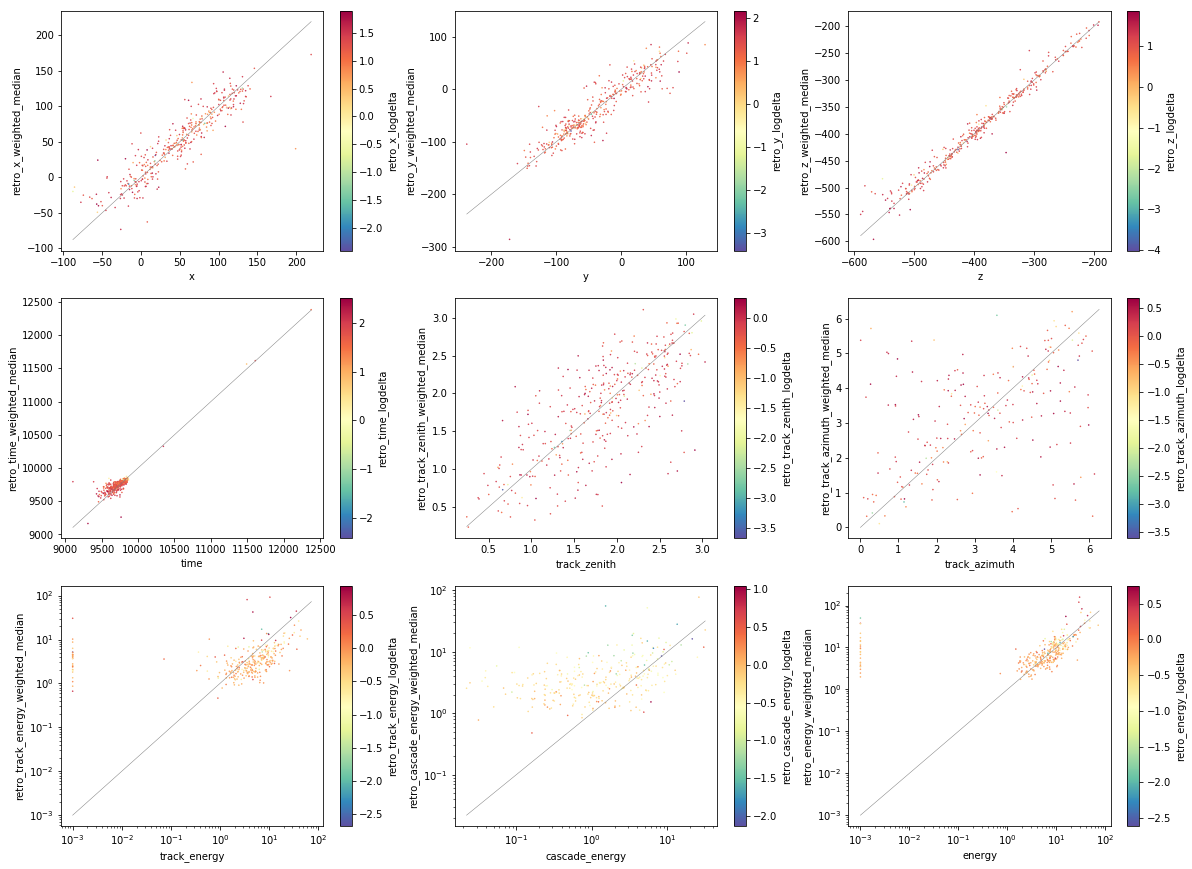

In [478]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=3, nrows=3)


for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy']):#, 'neutrino_energy']):
    print dim
    ax = axes[i//3,i%3]

    err_dim = dim
    
    if 'energy' in dim:
        events['retro_%s_logdelta'%err_dim] = np.log10(events['retro_%s_delta'%err_dim]/events['retro_%s_weighted_median'%err_dim] - 1)
    else:
        events['retro_%s_logdelta'%err_dim] = np.log10(events['retro_%s_delta'%err_dim])

    # diagonal
    d = [np.nanmin(events[dim]),np.nanmax(events[dim])]
    ax.plot(d,d, color='gray', linewidth=0.5)
    
    events.plot_2d(fig, ax, dim, 'retro_%s_weighted_median'%dim, c='retro_%s_logdelta'%err_dim, cmap='Spectral_r', s=0.3, alpha=1, cbar=True)
    if 'energy' in dim:
        ax.set_xscale('log')
        ax.set_yscale('log')
fig.savefig('error.png')

## Error vs. true Energy

In [7]:
def angular_dist(theta1, theta2, phi1, phi2):
    '''
    calculate the angular distance between two directions in spherical coords
    '''
    return np.arccos(np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1 - phi2))

/home/peller/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


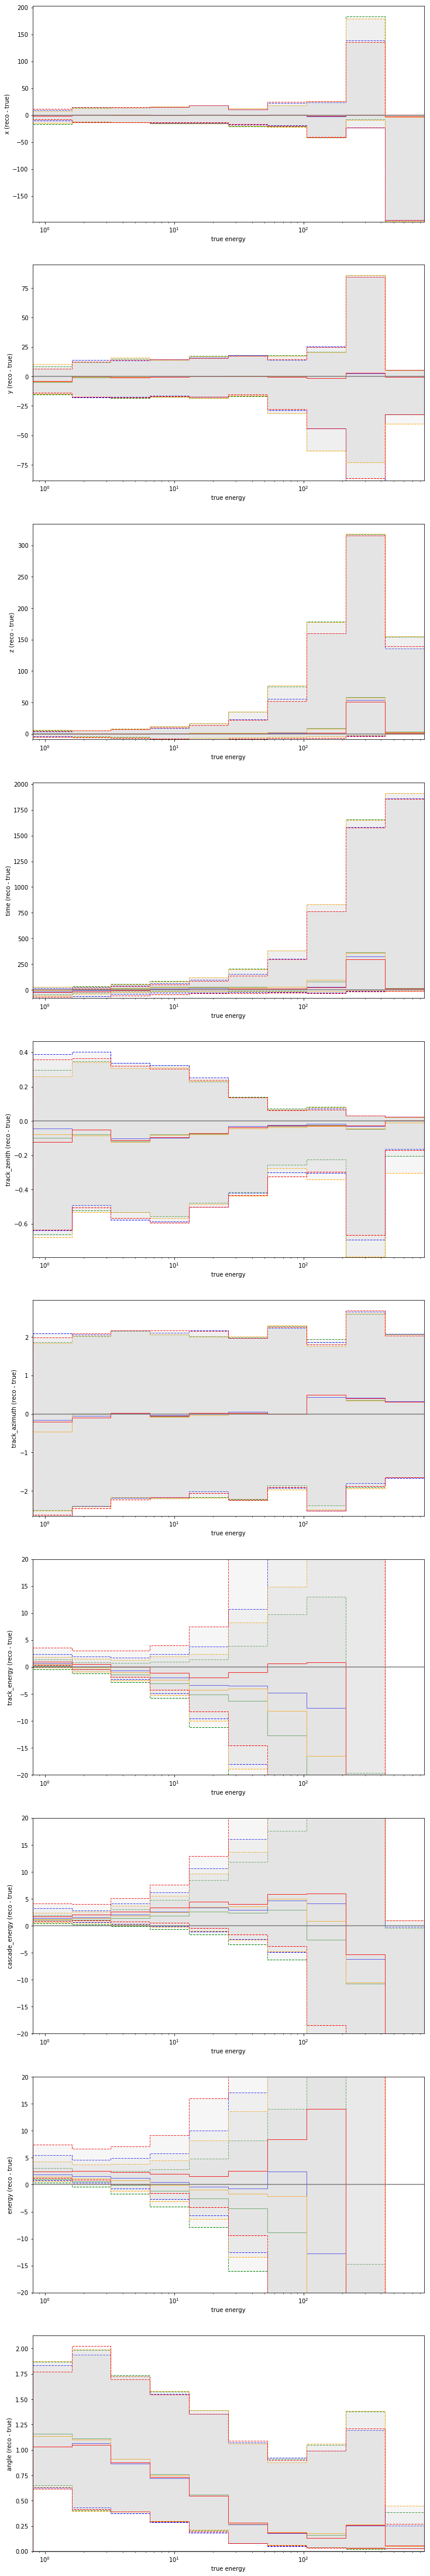

In [9]:
fig, axes = plt.subplots(figsize=(12, 80), ncols=1, nrows=10)
plt.subplots_adjust(hspace = 0.2)

res = []
pegres = []
speres = []

for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy', 'angle']):
    
    ax1 = axes[i]
    true_energy = np.nan_to_num(events['energy'])

    #for reco, color in zip(['spefit', 'retro', 'pegleg'], ['green', 'blue', 'orange']):
    for reco, color, estimator in zip(['retro', 'retro', 'retro', 'retro'], ['green', 'blue', 'orange', 'red'], ['_median', '_weighted_median', '_mean', '_weighted_mean']):
        if not ('energy' in dim and reco == 'spefit'):
            
            key = reco+'_'+dim+estimator
            d_key = reco+'_d_'+dim+estimator
            #print key
            
            if dim == 'angle':
                events[d_key] = angular_dist(events[reco+'_track_zenith'+estimator], events['track_zenith'], events[reco+'_track_azimuth'+estimator], events['track_azimuth'])
            else:
                events[d_key] = events[key] - events[dim]

            if 'azimuth' in dim:
                events[d_key]  = (events[key] + np.pi)%(2*np.pi) - np.pi

 
            hists[d_key] = events.histogram(d_key, function=np.percentile, q=50)
            hists[d_key+'_upper'] = events.histogram(d_key, function=np.percentile, q=84)
            hists[d_key+'_lower'] = events.histogram(d_key, function=np.percentile, q=16)

            hists.plot_step(fig, ax1, d_key, histtype='step', color=color, label=estimator)
            hists.plot_step(fig, ax1, d_key+'_lower', histtype='step', color=color, linestyle='--')
            hists.plot_step(fig, ax1, d_key+'_upper', histtype='step', color=color, linestyle='--')
            hists.plot_band(fig, ax1, d_key+'_lower', d_key+'_upper', color='lightgray', alpha=0.2, label=estimator)

    
    ax1.set_xlabel('true energy')

    if 'energy' in dim:
        ax1.set_ylim(-20, 20)

    ax1.set_ylabel('%s (reco - true)'%dim)
    ax1.set_xscale('log')
    ax1.set_xlim(true_energy[true_energy != 0].min(), true_energy.max())
    ax1.legend(loc='upper left',ncol=1, frameon=True,numpoints=1,fontsize=10)

    ax1.plot([0.01,1000],[0,0],ls='-', c='gray')
    plt.savefig('estimators.png')

In [291]:
np.sum(~np.isfinite(events['track_energy']))

0

In [314]:
events['pegleg_x']

array([  38.90707779,  -11.29794407,   55.91880035, ...,  -58.37524414,
         30.38212776,  162.378479  ], dtype=float32)

In [13]:
len(mask)

3512

In [38]:
events.mask = None
len(events['z'] > -550)

7130

In [45]:
np.sum(np.logical_and(events['retro_energy_logdelta'] < 0.2, events['retro_track_zenith_delta'] < 0.6))

3054

In [53]:
events['retro_x_weighted_median']

array([  33.14180374,   -9.1460619 ,  -15.3885498 , ...,  102.94122314,
         22.4485817 ,  148.75462341], dtype=float32)

In [68]:
events.mask = None

In [102]:
cm.Spectral(255)

(0.36862745098039218, 0.30980392156862746, 0.63529411764705879, 1.0)

In [251]:
np.percentile(events['energy'], q=0.01)

0.82051925687789917

In [294]:
truth_file.dtype.names

('pdg',
 'x',
 'y',
 'z',
 'time',
 'energy',
 'coszen',
 'azimuth',
 'unique_id',
 'highest_energy_daughter_pdg',
 'highest_energy_daughter_energy',
 'highest_energy_daughter_length',
 'highest_energy_daughter_coszen',
 'highest_energy_daughter_azimuth',
 'longest_daughter_pdg',
 'longest_daughter_energy',
 'longest_daughter_length',
 'longest_daughter_coszen',
 'longest_daughter_azimuth',
 'cascade_pdg',
 'cascade_energy',
 'cascade_coszen',
 'cascade_azimuth',
 'Crosssection',
 'EnergyLost',
 'GENIEWeight',
 'GlobalProbabilityScale',
 'InteractionProbabilityWeight',
 'InteractionType',
 'LengthInVolume',
 'OneWeight',
 'TargetPDGCode',
 'TotalInteractionProbabilityWeight')